In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [5]:
# Configuration pour des graphiques plus beaux
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42) # Pour la reproductibilité

In [7]:
# --- 1. Génération de données synthétiques (Le "Ground Truth") ---
def target_function(x):
    """Une fonction sinusoïdale simple pour simuler un phénomène physique."""
    return x * np.sin(x)

# On génère des points d'entraînement aléatoires (observations bruitées)
X_train = np.random.uniform(0, 10, 20).reshape(-1, 1) 
y_train = target_function(X_train).ravel()

# 2. On ajoute du bruit (Incertitude de mesure)
# Le bruit est hétéroscédastique (il varie selon les points)
dy = 0.5 + 1.0 * np.random.random(y_train.shape)
noise = np.random.normal(0, dy)
y_train += noise

print(f"Données générées : {len(X_train)} points d'observation bruité.")

Données générées : 20 points d'observation bruité.


In [9]:
# --- Cellule 3 : Définition et Entraînement du Processus Gaussien ---

# Définition du Noyau (Kernel) :
# - RBF (Radial Basis Function) : Gère la "douceur" de la courbe (corrélation spatiale).
# - WhiteKernel : Gère le bruit des données (explique pourquoi les points ne sont pas alignés).
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Création du modèle
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Entraînement (Inférence Bayésienne)
print("Entraînement du modèle en cours...")
gp.fit(X_train, y_train)

# Affichage des hyperparamètres appris par le modèle
print(f"Entraînement terminé !")
print(f"Kernel optimal appris : {gp.kernel_}")
print(f"Log-marginal-likelihood : {gp.log_marginal_likelihood(gp.kernel_.theta):.3f}")

Entraînement du modèle en cours...
Entraînement terminé !
Kernel optimal appris : 5.15**2 * RBF(length_scale=1.54) + WhiteKernel(noise_level=1.02)
Log-marginal-likelihood : -42.188


Calcul des prédictions et de l'incertitude...


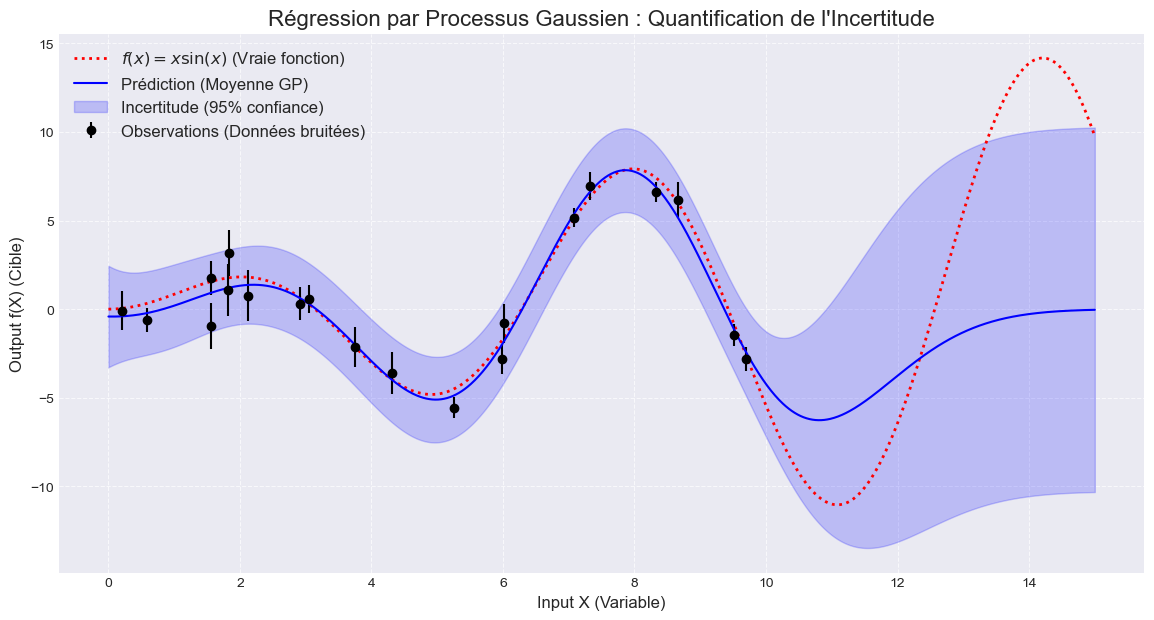

In [11]:
# --- Cellule 4 : Prédiction et Visualisation ---

# On veut prédire sur une zone plus large (0 à 15) pour voir l'extrapolation
X_test = np.linspace(0, 15, 1000).reshape(-1, 1)

# Prédiction : Le modèle renvoie la moyenne ET l'écart-type (sigma)
print("Calcul des prédictions et de l'incertitude...")
y_pred, sigma = gp.predict(X_test, return_std=True)

# --- Graphique ---
plt.figure(figsize=(14, 7))

# 1. La vraie fonction (inconnue du modèle)
plt.plot(X_test, target_function(X_test), 'r:', linewidth=2, label=r'$f(x) = x \sin(x)$ (Vraie fonction)')

# 2. Les observations (ce que le modèle a vu)
plt.errorbar(X_train.ravel(), y_train, dy, fmt='k.', markersize=12, label='Observations (Données bruitées)')

# 3. La prédiction du modèle
plt.plot(X_test, y_pred, 'b-', label='Prédiction (Moyenne GP)')

# 4. L'intervalle de confiance (Incertitude)
# On trace à 95% de confiance (1.96 * sigma)
plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                 alpha=0.2, color='blue', label='Incertitude (95% confiance)')

plt.title("Régression par Processus Gaussien : Quantification de l'Incertitude", fontsize=16)
plt.xlabel("Input X (Variable)", fontsize=12)
plt.ylabel("Output f(X) (Cible)", fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()